In [1]:
import numpy as np
import pandas as pd
from arch import arch_model

In [2]:
import matplotlib.pyplot as plt

In [3]:
class GarchSimulator:
    
    def __init__(self, mu, omega, alpha, beta):
        self.mu = mu
        self.omega = omega
        self.alpha = alpha
        self.beta = beta
        
        self.prev_epsilon = 0
        self.prev_sigma_sq = (1/(1-beta))*(omega + alpha)
        
    def get_next_return(self):
        et = np.random.normal(loc=0, scale=1)
        self.prev_sigma_sq = self.omega + self.alpha * (self.prev_epsilon**2) + self.beta * self.prev_sigma_sq
        self.prev_epsilon = et*np.sqrt(self.prev_sigma_sq)
        return self.mu + self.prev_epsilon

    def simulate(self, num):
        return np.array([self.get_next_return() for _ in range(num)])


class GarchSimulator2:
    
    def __init__(self, mu, omega, alpha, beta):
        self.mu = mu
        self.omega = omega
        self.alpha = alpha
        self.beta = beta
        
        self.prev_epsilon = 0
        self.prev_sigma_sq = (1/(1-beta))*(omega + alpha)
        
    def simulate(self, num):
        sim_mod = arch_model(np.random.randn(100))
        params = sim_mod.fit(update_freq=10).params
        params['mu'] = self.mu
        params['omega']= self.omega
        params['alpha[1]'] = self.alpha
        params['beta[1]'] = self.beta
        sim_mod = arch_model(None)
        sim_data = sim_mod.simulate(params, num)
        return sim_data['data'].to_numpy()


Simulate the data

In [144]:
simulator = GarchSimulator(mu=0.01, omega=0.0073, alpha=0.93, beta=0.06)
daily_simulated_data = simulator.simulate(13200)
monthly_simulated_data = np.sum(daily_simulated_data.reshape((600, 22)), axis=1)

In [174]:
import pandas as pd

In [201]:
daily_sp500_returns = pd.read_csv("sp500_daily.csv")['sprtrn'].to_numpy()
monthly_sp500_returns = pd.read_csv("sp500_monthly.csv")['sprtrn'].to_numpy()

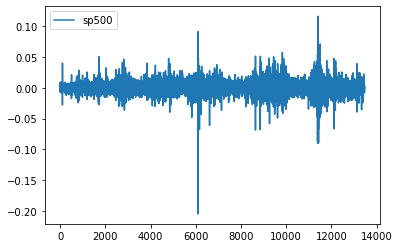

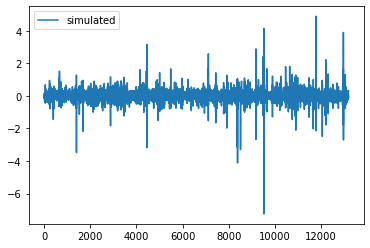

In [202]:
plt.plot(daily_sp500_returns.astype(float), label='sp500')
plt.legend()
plt.show()
plt.plot(daily_simulated_data, label='simulated')
plt.legend()
plt.show()

## 2

### SP500

In [203]:
sp500_monthly_garch_model = arch_model(monthly_sp500_returns)
sp500_monthly_garch_fitted = sp500_monthly_garch_model.fit(update_freq=10)
sp500_monthly_garch_fitted.params

Iteration:     10,   Func. Count:     79,   Neg. LLF: -1145.8691408452733
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1145.8720174331459
            Iterations: 12
            Function evaluations: 89
            Gradient evaluations: 12


/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/arch/univariate/base.py:293: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001806. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning


mu          0.007172
omega       0.000063
alpha[1]    0.118205
beta[1]     0.855036
Name: params, dtype: float64

Omega is quite small for the sp500 data

### Simulated

In [197]:
sim_monthly_garch_model = arch_model(monthly_simulated_data)
sim_monthly_garch_fitted = sim_monthly_garch_model.fit(update_freq=10)
sim_monthly_garch_fitted.params

Iteration:     10,   Func. Count:     60,   Neg. LLF: 1017.0668584827089
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1017.0668584827597
            Iterations: 10
            Function evaluations: 60
            Gradient evaluations: 10


mu          0.211953
omega       0.329447
alpha[1]    0.114748
beta[1]     0.722009
Name: params, dtype: float64

Here we see that $\omega$ is much larger for the simulated data than the sp500 data, and as we should expect, $\mu$ is around 22x the $\mu$ we specified for the daily simulated data

##  3

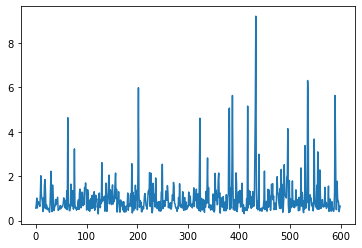

In [207]:
sim_realized_vol = np.sqrt(np.sum(np.square(daily_simulated_data.reshape((600, 22))), axis=1))
plt.plot(sim_realized_vol)
plt.show()

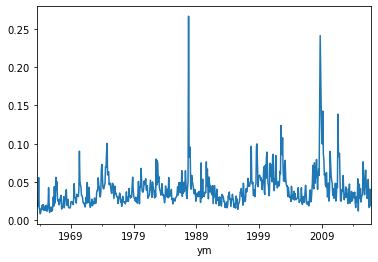

In [208]:
daily = pd.read_csv('sp500_daily.csv')
daily['ym'] = daily['caldt'].apply(lambda x: int(x/100))
daily['ym'] = pd.to_datetime(daily['ym'], format='%Y%m')
daily['caldt'] = pd.to_datetime(daily['caldt'], format='%Y%m%d')
daily.set_index('caldt', inplace=True)

daily['rsq'] = daily['sprtrn'] ** 2
monthly_real_vol = np.sqrt(daily.groupby('ym')[['rsq']].sum())
monthly_real_vol['lag1'] = monthly_real_vol['rsq'].shift(1)

monthly_real_vol['rsq'].plot()
plt.show()
sp500_realized_vol = monthly_real_vol['rsq'].to_numpy()

The volatility of the simulated data is not only higher on average than the sp500 data, it also exhibits more frequent spikes

## 4

### plot for sp500 data

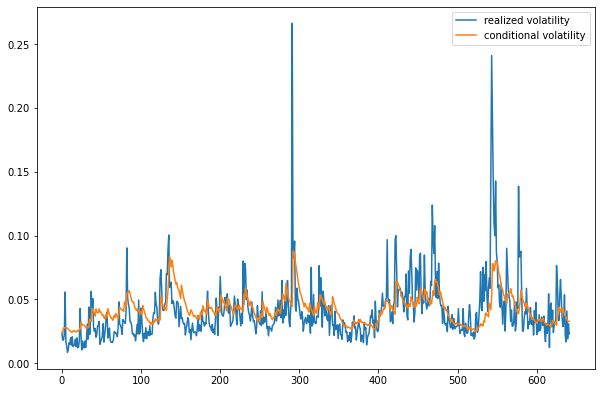

In [206]:
plt.figure(figsize=(10,6.66))

plt.plot(sp500_realized_vol, label="realized volatility")
plt.plot(sp500_monthly_garch_fitted.conditional_volatility,
         label="conditional volatility")
plt.legend()
plt.show()

### Plot for simulated data

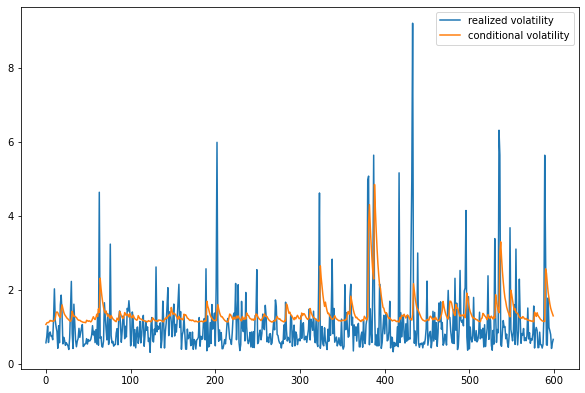

In [184]:
plt.figure(figsize=(10,6.66))

plt.plot(sim_realized_vol, label="realized volatility")
plt.plot(sim_monthly_garch_fitted.conditional_volatility, label="conditional volatility")
plt.legend()

plt.show()

## 5 

In [185]:
import statsmodels

In [186]:
from statsmodels.tsa.ar_model import AutoReg

### simulated data

In [187]:
sim_ar_model = AutoReg(sim_realized_vol, lags=1, old_names=False)
sim_ar_model_fit = sim_ar_model.fit()
sim_ar_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                      y   No. Observations:                  600
Model:                     AutoReg(1)   Log Likelihood                -735.322
Method:               Conditional MLE   S.D. of innovations              0.826
Date:                Wed, 17 Feb 2021   AIC                             -0.373
Time:                        11:03:25   BIC                             -0.351
Sample:                             1   HQIC                            -0.364
                                  600                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7536      0.052     14.364      0.000       0.651       0.856
y.L1           0.2602      0.039      6.595      0.000       0.183       0.337
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            3.8439           +0.0000j            3.8439            0.0000
-----------------------------------------------------------------------------
"""

The AR model for the simulated data has a high mean, and a somewhat low autocorrelation.

### sp500 data

In [188]:
sp_ar_model = AutoReg(sp500_realized_vol, lags=1, old_names=False)
sp_ar_model_fit = sp_ar_model.fit()
sp_ar_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                      y   No. Observations:                  642
Model:                     AutoReg(1)   Log Likelihood                1670.182
Method:               Conditional MLE   S.D. of innovations              0.018
Date:                Wed, 17 Feb 2021   AIC                             -8.040
Time:                        11:03:25   BIC                             -8.019
Sample:                             1   HQIC                            -8.032
                                  642                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0138      0.001      9.931      0.000       0.011       0.017
y.L1           0.6564      0.030     22.028      0.000       0.598       0.715
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.5235           +0.0000j            1.5235            0.0000
-----------------------------------------------------------------------------
"""

The AR model for the sp500 data has a higher autocorollation and and much lower mean than the simulated data.

## 6

### sp500 data

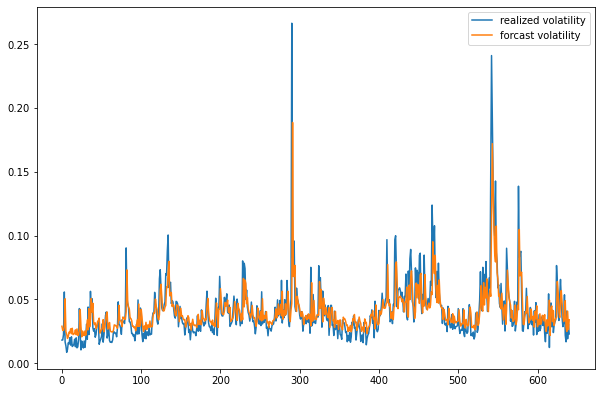

In [189]:
plt.figure(figsize=(10,6.66))
mu, l = sp_ar_model_fit.params
sp_sigma_t_ar_preds = mu + l * sp500_realized_vol[:-1]
plt.plot(sp500_realized_vol[1:], label='realized volatility')
plt.plot(sp_sigma_t_ar_preds, label='forcast volatility')
plt.legend()
plt.show()

### simulated data

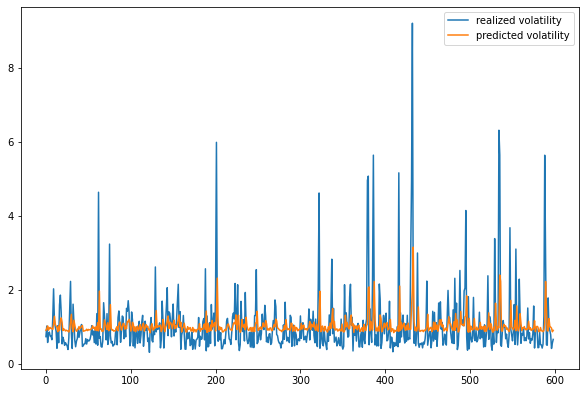

In [190]:
plt.figure(figsize=(10,6.66))
mu, l = sim_ar_model_fit.params
sim_sigma_t_ar_preds = mu + l * sim_realized_vol[:-1]
plt.plot(sim_realized_vol[1:], label='realized volatility')
plt.plot(sim_sigma_t_ar_preds, label='predicted volatility')
plt.legend()
plt.show()

## 7

sp500 AR MSE

In [191]:
np.mean(np.square(sp_sigma_t_ar_preds - sp500_realized_vol[1:]))

0.00031940460439069696

simulated AR MSE

In [209]:
np.mean(np.square(sim_sigma_t_ar_preds - sim_realized_vol[1:]))

0.6820104578301431

## 8

### SP500

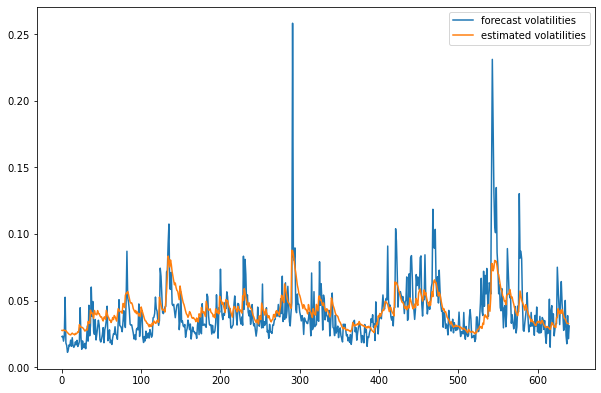

In [194]:
plt.figure(figsize=(10,6.66))
mu = sp500_monthly_garch_fitted.params['mu']
alpha = sp500_monthly_garch_fitted.params['alpha[1]']
beta = sp500_monthly_garch_fitted.params['beta[1]']
omega = sp500_monthly_garch_fitted.params['omega'] 
epsilon_ts = monthly_sp500_returns.astype(float) - mu
sp_sigma_ts = sp500_monthly_garch_fitted.conditional_volatility[1:]
sp_sigma_t_preds = np.sqrt(omega + alpha * epsilon_ts[:-1]**2 + beta * sp500_realized_vol[:-1]**2)

plt.plot(sp_sigma_t_preds, label="forecast volatilities")
plt.plot(sp_sigma_ts[1:], label="estimated volatilities")
plt.legend()
plt.show()

### Simulated 

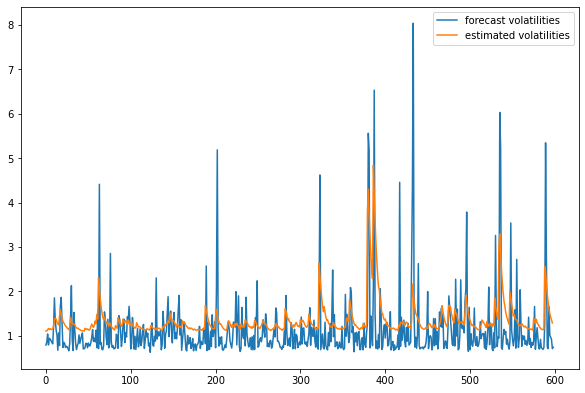

In [210]:
mu = sim_monthly_garch_fitted.params['mu']
alpha = sim_monthly_garch_fitted.params['alpha[1]']
beta = sim_monthly_garch_fitted.params['beta[1]']
omega = sim_monthly_garch_fitted.params['omega'] 
epsilon_ts = monthly_simulated_data - mu
sim_sigma_ts = sim_monthly_garch_fitted.conditional_volatility[1:]
sim_sigma_t_preds = np.sqrt(omega + alpha * epsilon_ts[:-1]**2 + beta * sim_realized_vol[:-1]**2)

plt.figure(figsize=(10,6.66))
plt.plot(sim_sigma_t_preds, label="forecast volatilities")
plt.plot(sim_sigma_ts[1:], label="estimated volatilities")
# plt.plot(np.square(sigma_ts[1:] - sigma_t_preds), label="deltas")
plt.legend()
plt.show()

## 9

sp500 MSE

In [195]:
np.mean(np.square(sp_sigma_t_preds - sp_sigma_ts))

0.00029571390519508877

simulated MSE

In [196]:
np.mean(np.square(sim_sigma_t_preds - sim_sigma_ts))

0.4660424813139552

We see here that the MSE for both datasets is lower with the forcasts from the GARCH model compated to the AR model.